# Part 1: Imports and Set-up

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import scipy
import matplotlib.pyplot as plt
import numpy as np

import math
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import os
from sklearn.model_selection import train_test_split
import time
import torch.nn.functional as F

currDir = "/content/drive/My Drive/CS445_Data/Final_Project_Code/"
inputsDir = currDir + "other inputs/"
outputsDir = currDir + "Outputs/"
paper1InputsDir = inputsDir + "paper1/"
paper2InputsDir = inputsDir + "paper2/"

# Uses Laplacian matrix implementation from following
!pip install git+https://github.com/pymatting/pymatting

from pymatting import cf_laplacian

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pymatting/pymatting to /tmp/pip-req-build-owjng83e
  Running command git clone --filter=blob:none --quiet https://github.com/pymatting/pymatting /tmp/pip-req-build-owjng83e
  Resolved https://github.com/pymatting/pymatting to commit f3641285c5abc50bde3a252508b7cd6477d47909
  Preparing metadata (setup.py) ... done


# Part 2: Implementation of Paper 1 - “Single Image Haze Removal Using Dark Channel Prior” by He et al.

In [181]:
def get_dark_channel_priors(red_image, green_image, blue_image, num_rows, num_cols, patch_size, show_figure=True):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
  red_image_mins = cv2.erode(red_image, kernel)
  green_image_mins = cv2.erode(green_image, kernel)
  blue_image_mins = cv2.erode(blue_image, kernel)
  rgb_image_mins = np.stack((red_image_mins, green_image_mins, blue_image_mins), axis=1)
  dark_channel_priors = np.min(rgb_image_mins, axis=1)
  
  # if show_figure:
  #   plt.figure()
  #   plt.title("Original Image Dark Channel Priors")
  #   plt.imshow(dark_channel_priors, cmap="gray")

  return dark_channel_priors

In [ ]:
def estimate_atmospheric_light(dark_channel_priors, image, brightest_threshold=0.001):
  num_rows, num_cols, channels = image.shape

  num_brightest = np.ceil(image.shape[0] * image.shape[1] * brightest_threshold).astype("int")
  brightest_idxs = np.argsort(dark_channel_priors.flatten())[-num_brightest:]
  brightest_idxs_tuple = np.unravel_index(brightest_idxs, (num_rows, num_cols))

  atmospheric_light = None
  for y, x in zip(brightest_idxs_tuple[0], brightest_idxs_tuple[1]):
    average_intensity = np.mean((image[y,x,0], image[y,x,1], image[y,x,2]))
    if atmospheric_light is None or average_intensity > np.mean(atmospheric_light):
      atmospheric_light = np.array([image[y,x,0], image[y,x,1], image[y,x,2]])

  return atmospheric_light

In [180]:
def estimate_transmission(atmospheric_light, image, red_image, green_image, blue_image, num_rows, num_cols, patch_size, w=0.95):
  # Get unrefined transmission map.
  dark_channel_normalized \
    = get_dark_channel_priors(red_image / atmospheric_light[0], green_image / atmospheric_light[1], blue_image / atmospheric_light[2], num_rows, num_cols, patch_size, show_figure=False)
  t_tild = 1 - w * dark_channel_normalized

  # plt.figure()
  # plt.title("Unrefined Transmission Estimate")
  # plt.imshow(t_tild, cmap="gray")

  # Get refined transmission map.
  L = cf_laplacian(image)
  U = scipy.sparse.identity(L.shape[0])
  lam = 10**-4
  t = scipy.sparse.linalg.spsolve(L + lam * U, lam * t_tild.flatten())
  t = t.reshape((t_tild.shape))

  # plt.figure()
  # plt.title("Refined Transmission Estimate")
  # plt.imshow(t, cmap='gray')
  
  return t



In [ ]:
def estimate_radiance(image_channel, atmospheric_light_channel, transmission_map, t0=0.01):
  return (image_channel - atmospheric_light_channel) / np.maximum(transmission_map, t0) + atmospheric_light_channel

In [170]:
# Input: image - image with RGB channels
# Output: image_ - dehazed image with RGB channels
def haze_removal_using_dark_channel_prior(image):
  num_rows, num_cols, channels = image.shape

  assert channels == 3

  patch_size = 7
  red_image = image[:,:,0]
  green_image = image[:,:,1]
  blue_image = image[:,:,2]
  dark_channel_priors = get_dark_channel_priors(red_image, blue_image, green_image, num_rows, num_cols, patch_size)

  A = estimate_atmospheric_light(dark_channel_priors, image)
  t = estimate_transmission(A, image, red_image, blue_image, green_image, num_rows, num_cols, patch_size)
  
  dehazed_image = np.stack([estimate_radiance(image[:,:,0], A[0], t),
                            estimate_radiance(image[:,:,1], A[1], t),
                            estimate_radiance(image[:,:,2], A[2], t)],
                            axis=2)

  return dehazed_image

  

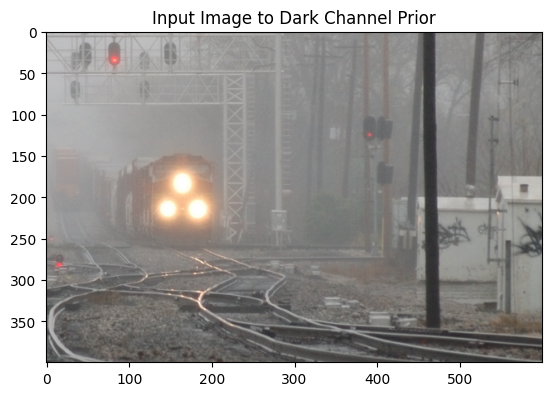

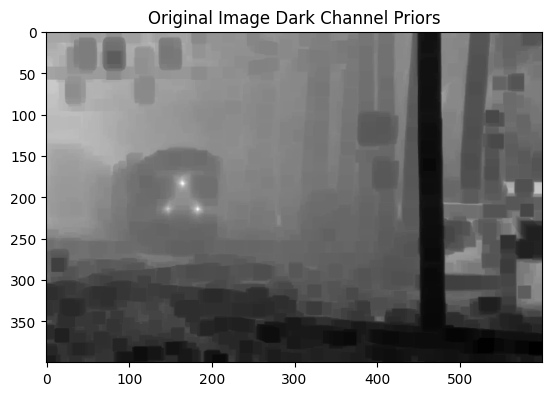

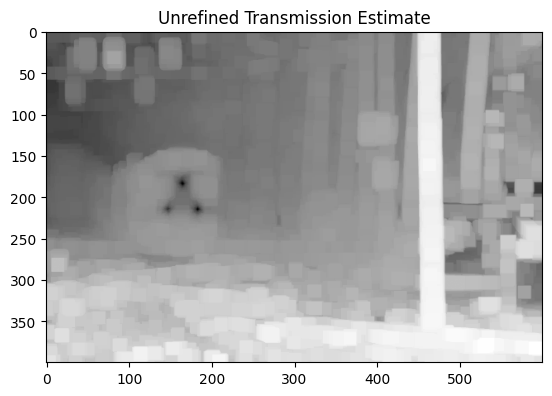

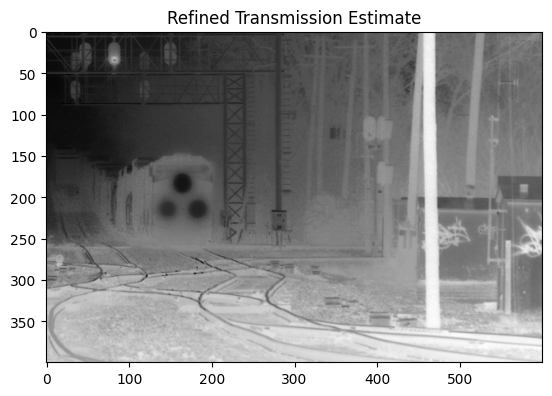

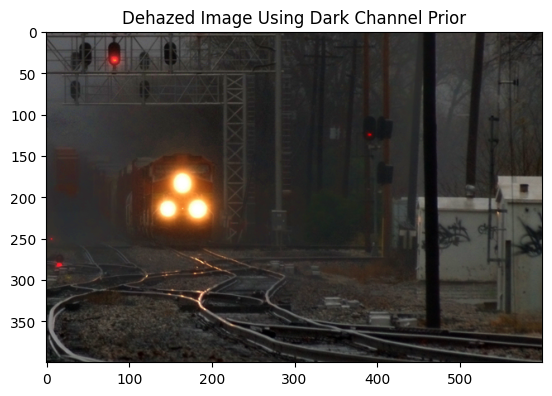

In [ ]:
# Driver code
def run_hazel_removal_using_dark_channel_prior(input_image_name, output_image_name):
  input_image = cv2.cvtColor(cv2.imread(paper1InputsDir + input_image_name), cv2.COLOR_BGR2RGB).astype("float") / 255.0
  plt.figure()
  plt.title("Input Image to Dark Channel Prior")
  plt.imshow(input_image)

  dark_channel_prior_dehazed_image = haze_removal_using_dark_channel_prior(input_image)
  plt.figure()
  plt.title("Dehazed Image Using Dark Channel Prior")
  plt.imshow(dark_channel_prior_dehazed_image)
  cv2.imwrite(outputsDir + output_image_name, cv2.cvtColor((dark_channel_prior_dehazed_image * 255.0).astype("uint8"), cv2.COLOR_RGB2BGR))

run_hazel_removal_using_dark_channel_prior("Train_From_He_et_al.png", "Train_From_He_et_al_output.png")

# Part 3: Implementation of Paper 2 - “A Retinex-Based Enhancing Approach for Single Underwater Image” by Fu et al.


In [ ]:
# Input: im - image with RGB channels (the sequence is RGB)
# Output: im_ - image with RGB channels (the sequence is RGB)
def RETINEX_BASED(im):
    mu = 2.3
    H,W,garbage = np.shape(im)

    ################################################### Color Correction ########################################################
    im_c = im*255
    for i in range(3):
        var = np.sum((im_c[:,:,i]-np.mean(im_c[:,:,i]))**2)/(H*W)
        var = np.sqrt(var)
        mx = np.mean(im_c[:,:,i])+mu*var
        mn = np.mean(im_c[:,:,i])-mu*var
        x = (im_c[:,:,i]-mn)/(mx-mn)*255
        # x[x>1] = 1
        # x[x<0] = 0
        x[x>255] = 255
        x[x<0] = 0
        im_c[:,:,i] = x*1
        print(np.min(im_c),np.max(im_c))
    im_c = im_c.astype(int)
    im_c = np.float32(im_c/255)
    im_c_lab = cv2.cvtColor(im_c,cv2.COLOR_RGB2LAB)


    ################################################### Calculate I0 ########################################################
    sigma = 5;
    window_size = 3*sigma    
    gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)
    L = im_c_lab*1
    L[:,:,0] = L[:,:,0]/100*255
    I0 = np.abs(cv2.filter2D(L[:,:,0], -1, gaussian_kernel_2d))

    ################################################### Parameters ########################################################
    lamb = 10
    alpha = 100
    beta = 0.1
    gamma = 1

    ###################################################### Loop ###########################################################

    #-------------- Initialize ----------------#
    R = np.zeros(np.shape(L[:,:,0]))
    I = I0*1

    #---------------- Shrink ------------------#
    diff_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    diff_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

    dx = cv2.filter2D(R,-1,diff_x)
    dy = cv2.filter2D(R,-1,diff_y)

    max_dx = np.abs(dx)-0.5/lamb
    dx = (max_dx>0).astype(float)*max_dx*((dx>=0).astype(float)-(dx<0).astype(float))

    max_dy = np.abs(dy)-0.5/lamb
    dy = (max_dy>0).astype(float)*max_dy*((dy>=0).astype(float)-(dy<0).astype(float))

    #---------------- R ------------------#
    one = np.zeros(np.shape(L[:,:,0]))
    # one[int(np.shape(one)[0]/2),int(np.shape(one)[1]/2)] = 1
    one[0,0] = 1

    if np.min(I)==0:
        I+=1e-10
    R_1 = (1+beta*lamb)*np.fft.fft2(L[:,:,0]/I)
    R_2 = np.fft.fft2(one) + beta*lamb*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx)) + np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
    R_ = R_1/R_2
    R = np.abs(np.fft.ifft2(R_))

    #---------------- I ------------------#
    one = one*(1+gamma)
    if np.min(R)==0:
        R+=1e-20
    I_1 = np.fft.fft2(gamma*I0+L[:,:,0]/R)
    I_2 = np.fft.fft2(one)+alpha*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx))+np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
    I_ = I_1/I_2
    I = np.real(np.fft.ifft2(I_))
    I = (I>=L[:,:,0]).astype(float)*I+(I<L[:,:,0]).astype(float)*L[:,:,0]

    #--------------- remap ---------------#
    decimal = 1
    C = np.zeros(230*decimal+1)
    for i in range(230*decimal+1):
        if i==0:
            C[i] = np.arctan(0-15)
        else:
            C[i] = C[i-1]+np.arctan(i/decimal-15)
    C = C/C[230*decimal]

    I_new = np.round(I*decimal)
    upper_bound = np.int(np.max(np.round(I*decimal))+1)
    sum = 0
    for i in range(upper_bound):
        sum += np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))
    # print(sum)
    for i in range(upper_bound):
        c = np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))/sum
        idx = np.argmax(C>=c)
        I_new[np.round(I*decimal)==i] = idx
    I_new = I_new/decimal
    # I = I_new*1

    #------------- update ----------------#
    # L_ = L*1
    # L_[:,:,0] = R*I/np.max(R)
    # L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
    # return L_
    L_ = L*1
    L_[:,:,0] = R*I/255*100/2
    L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
    return L_


    
    

In [ ]:
pic_name = '1.png'
im = np.array(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0)
plt.imshow(im)
plt.show()
plt.imshow(RETINEX_BASED(im))
plt.show()

error: ignored

# Part 4: Underwater or Not Image Classifier


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, models, transforms
# import os
# from sklearn.model_selection import train_test_split



In [ ]:
currDir = "/content/drive/My Drive/CS445_Data/Final_Project_Code/"
inputsDir = currDir + "Inputs/"
outputsDir = currDir + "Outputs/"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
}
dataset = datasets.ImageFolder(root=inputsDir, transform=data_transforms['train'])

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(nn.Conv2d(3, 12, 2, padding=1),nn.MaxPool2d(6, stride=2),nn.Flatten(),nn.Linear(2352, 16),
#             nn.ReLU(),nn.Linear(16, 2))


#     def forward(self, x):
#         x = x.reshape(-1, 3, 31, 31)
#         return self.model(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


classes = ('land','underwater')

In [ ]:
model = model.to(device)


num_epochs = 4



model = model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    t_s = time.time()

    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


print('Finished Training')

        

Finished Training


In [ ]:
# PATH = './cifar_net.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
# PATH = './cifar_net.pth'

# model = model.to(device)
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

<ipython-input-59-fa81c1aed30a>:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_bound = np.int(np.max(np.round(I*decimal))+1)


mean: 0.1398770528547965


mean: 0.41905557342891897


mean: 0.27478122477494077
Accuracy of the network on the test images: 99%


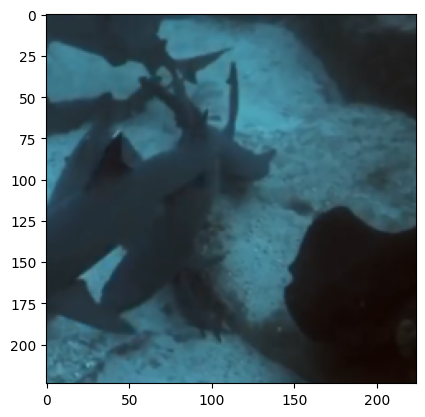

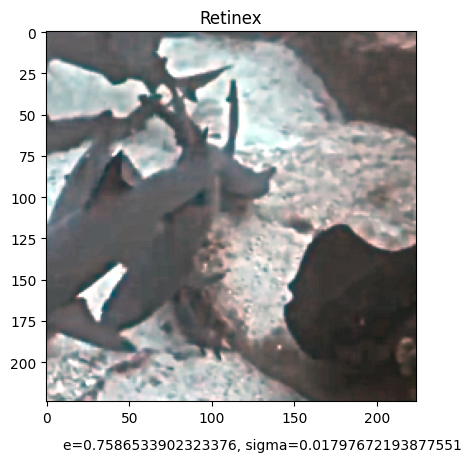

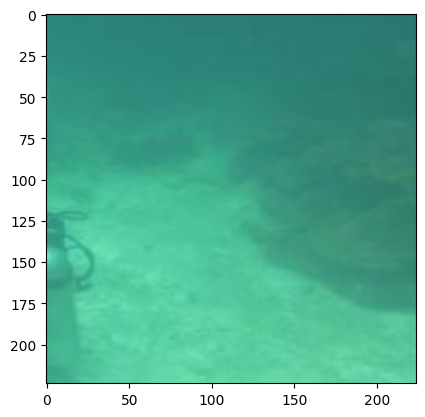

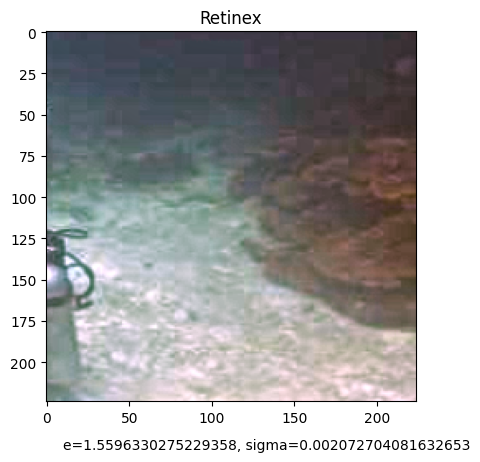

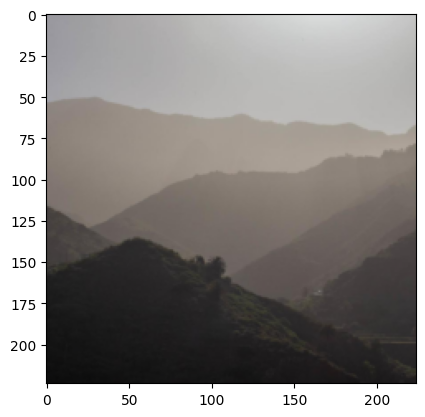

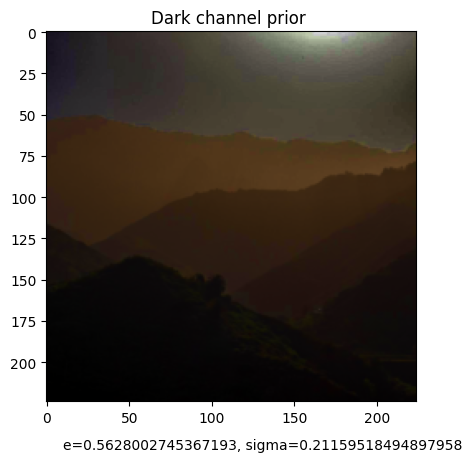

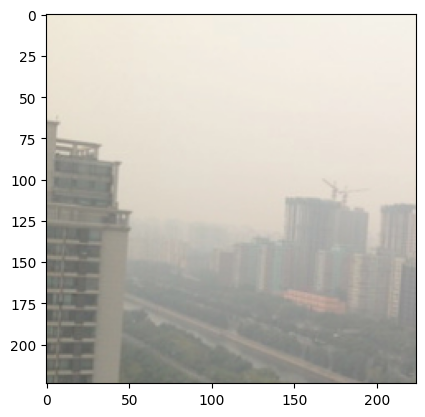

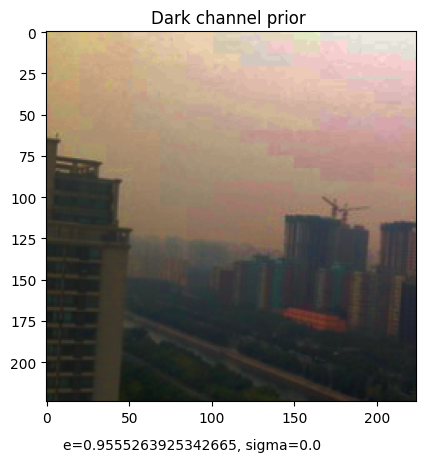

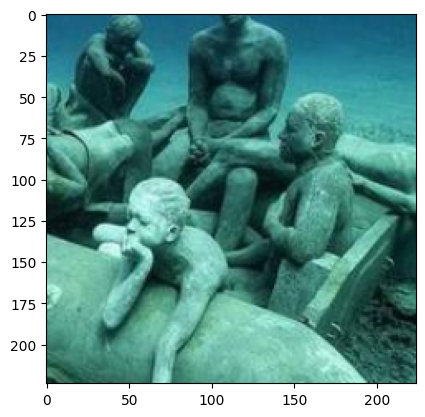

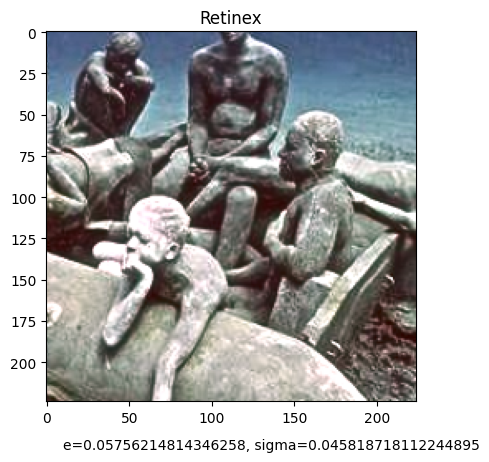

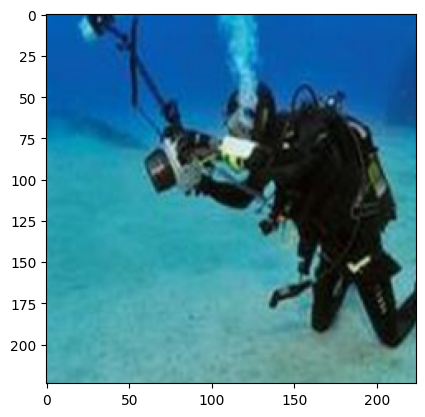

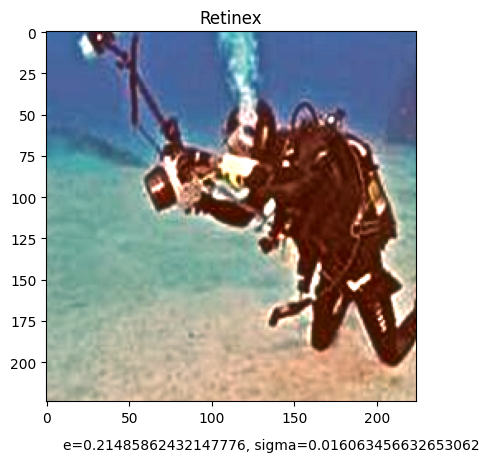

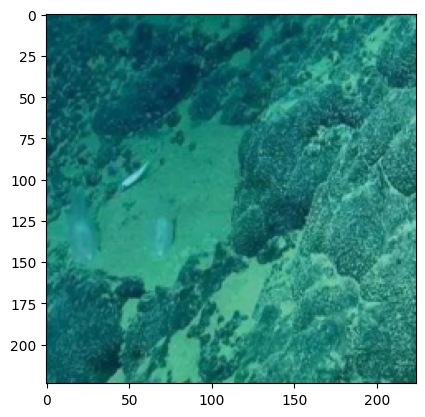

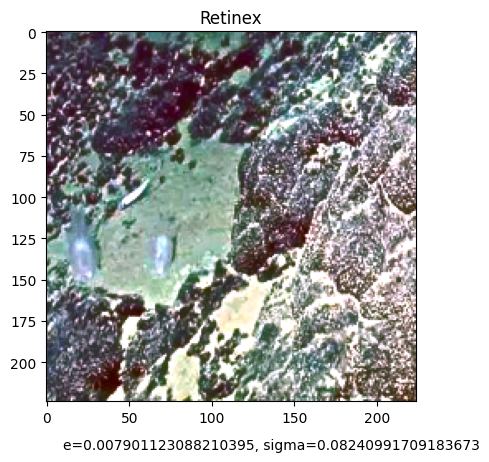

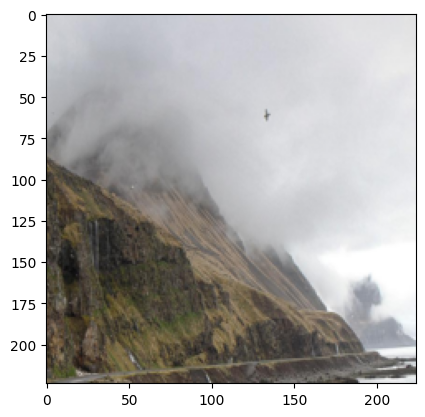

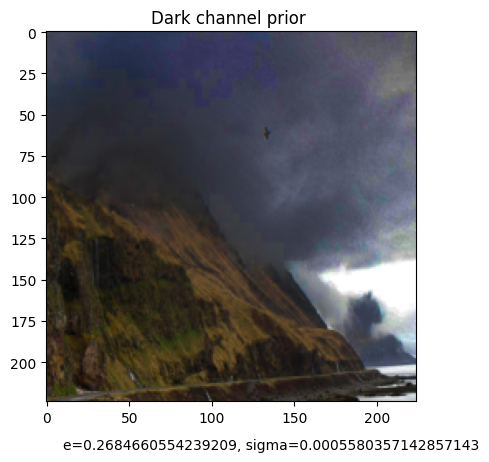

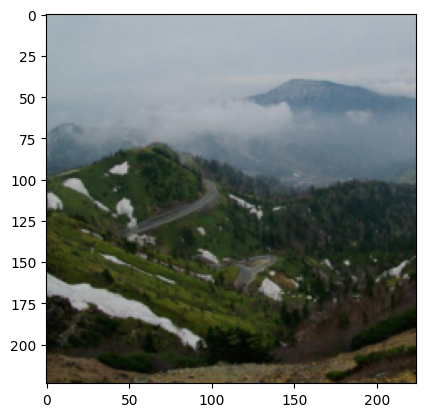

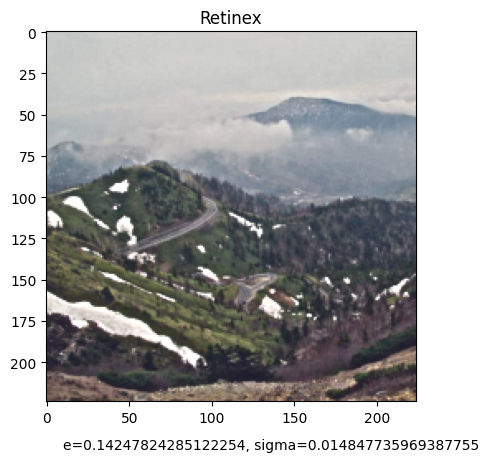

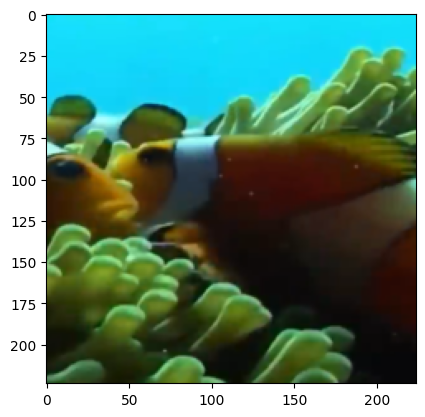

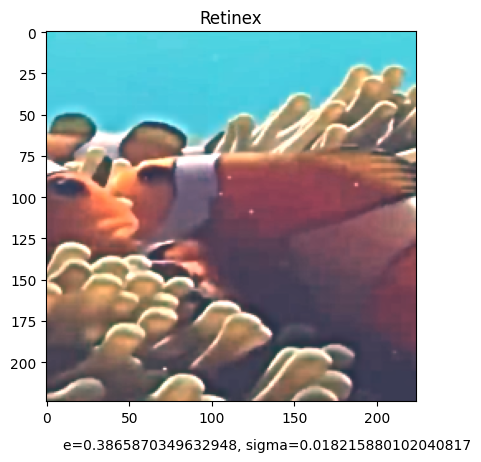

In [209]:

correct = 0
total = 0
model.eval()
with torch.no_grad():
    i =0
    for data in testloader:
        images, labels = data
        #imshow(images[0])
        img = images[0]
        img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
        img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
        img = img.numpy().astype(np.float64)#.reshape((224,224,3))
        img = np.transpose(img, (1, 2, 0))

        if(  i <=10):
          classify_and_dehaze(img)
          i+=1

        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        


print('Accuracy of the network on the test images: %d%%' % (
    100 * correct / total))

In [205]:
def classify_and_dehaze(img):
  img = img.astype(np.float32)

  img_tens = transforms.ToTensor()(img)
  img_tens = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img_tens)


  
  plt.figure()
  plt.imshow(img)


  convert_tensor = transforms.ToTensor()

  outputs = model(img_tens.unsqueeze(0).to(device))
  #print(outputs.data)
  _, predicted = torch.max(outputs.data, 1)
  # print(predicted)
  if(predicted >= 1):
    img_underwater = RETINEX_BASED(img)
    plt.figure()
    plt.title("Retinex" )
    plt.figtext(.25, .01, "e={}, sigma={}".format(evaluation_e(img,  np.clip(img_underwater,0,1) ),evaluation_sigma(img, np.clip( img_underwater, 0,1)))   )


    plt.imshow(img_underwater)


    
    return img_underwater

    #cv2.imwrite(outputsDir + "underwater", cv2.cvtColor((img_underwater * 255.0).astype("uint8"), cv2.COLOR_RGB2BGR))

  else:
    img_new = img.astype('float64')

    img_dark = haze_removal_using_dark_channel_prior(img_new)
    plt.figure()
    plt.title("Dark channel prior ")
    plt.imshow(img_dark)
    plt.figtext(0.25, .01, "e={}, sigma={}".format(evaluation_e(img, np.clip(img_dark, 0,1)),evaluation_sigma(img, np.clip(img_dark, 0,1)))   )

    return img_dark
    #cv2.imwrite(outputsDir + "darkchannel", cv2.cvtColor((img_dark * 255.0).astype("uint8"), cv2.COLOR_RGB2BGR))

  


# Part 5: Evaluation

In [198]:
# input: original & dehaze image
# output: evaluation e value
def evaluation_e(original, dehaze):
    if np.max(original)<=1:
        original_ = original*255
    else:
        original_ = original*1
    if np.max(dehaze)<=1:
        dehaze_ = dehaze*255
    else:
        dehaze_ = dehaze*1
    edges_origin = cv2.Canny(np.uint8(original_), threshold1=10, threshold2=35)
    edges_dehaze = cv2.Canny(np.uint8(dehaze_), threshold1=10, threshold2=35)
    # plt.figure()
    # plt.imshow(edges_origin,cmap='gray')
    # plt.figure()
    # plt.imshow(edges_dehaze,cmap='gray')
    return (np.sum(edges_dehaze)-np.sum(edges_origin))/np.sum(edges_origin)

In [157]:
# input: original & dehaze should be in RGB sequence
#        threshold_uppor: the value large than this is regarded as saturated (black)
#        threshold_lower: the value smaller than this is regarded as saturated (white)
# output: evaluation sigma value
def evaluation_sigma(original, dehaze, threshold_upper=250, threshold_lower=10):
    H,W,garbage = np.shape(original)
    if np.max(original)<=1:
        original_ = np.uint8(original*255)
    else:
        original_ = np.uint8(original*1)
    if np.max(dehaze)<=1:
        dehaze_ = np.uint8(dehaze*255)
    else:
        dehaze_ = np.uint8(dehaze*1)
    original_gray = cv2.cvtColor(original_, cv2.COLOR_RGB2GRAY)
    dehaze_gray = cv2.cvtColor(dehaze_, cv2.COLOR_RGB2GRAY)
    sigma = np.sum((dehaze_gray>threshold_upper)*(1-(original_gray>threshold_upper)))
    sigma+= np.sum((dehaze_gray<threshold_lower)*(1-(original_gray<threshold_lower)))
    return 1.0*sigma/(H*W)